In [6]:
import pandas as pd
import os

datadir = 'controller_output'

columns = ["steering", "throttle", "speed", "t_list"]
# Skip the first recording that had been set to 0 for initialization of the variables
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'),names = columns, skiprows=1)
data

,steering,throttle,speed,t_list
0,0.999,0.100,0.000,0.020
1,0.999,0.200,0.000,0.420
2,0.999,0.300,0.001,0.820
3,0.999,0.400,0.008,1.220
4,0.999,0.500,0.041,1.620
...,...,...,...,...
1165,-0.009,0.919,22.198,466.004
1166,-0.011,0.919,22.204,466.404
1167,-0.014,0.918,22.211,466.804
1168,-0.016,0.917,22.219,467.204


<AxesSubplot:>

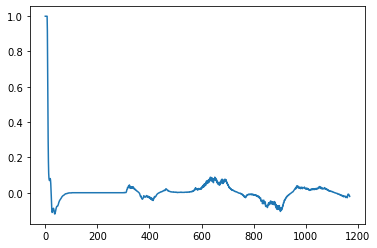

In [7]:
data['steering'].plot()

<AxesSubplot:>

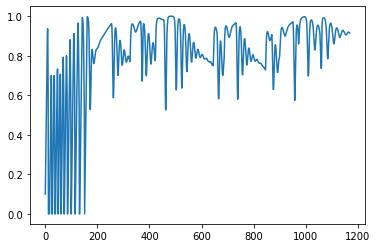

In [8]:
data['throttle'].plot()

<AxesSubplot:>

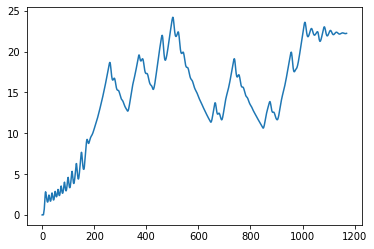

In [9]:
data['speed'].plot()

In [22]:
from IPython.display import display
import ipywidgets as widgets
w = widgets.IntSlider(value=274,min=74,max=1243)
display(w)

IntSlider(value=274, max=1243, min=74)

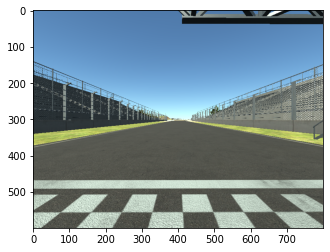

In [25]:
import matplotlib.image as mpimg
i = w.value
# i = 10
img_path = '_out/frame_CameraRGB/{:0>6d}.png'.format(i)
img = mpimg.imread(img_path)
plt.imshow(img)


## Prepare Data

Start from the finish line (200th frame)

In [10]:
data['center'] =os.listdir('_out/frame_CameraRGB')

In [27]:
data.iloc[200]

steering           0.0
throttle         0.838
speed           10.555
t_list           80.02
center      000274.png
Name: 200, dtype: object

In [28]:
data['steering'][200:]

200     0.000
201     0.000
202     0.000
203     0.000
204     0.000
        ...  
1165   -0.009
1166   -0.011
1167   -0.014
1168   -0.016
1169   -0.021
Name: steering, Length: 970, dtype: float64

total data: 970


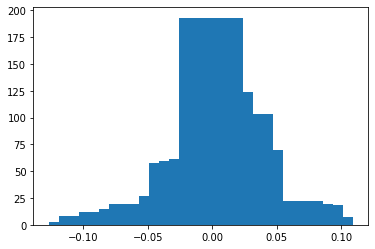

In [31]:
import numpy as np
import matplotlib.pyplot as plt

num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'][200:], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
print('total data:', len(data[200:]))

In [39]:
def load_img_steering(datadir, data):
  image_path = []
  steering = []
  for i in range(len(data)):
    center = data['center'].iloc[i]
    image_path.append(os.path.join(datadir, center))
    steering.append(data['steering'].iloc[i])
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings
 
image_paths, steerings = load_img_steering('_out/frame_CameraRGB', data[200:])
image_paths, steerings

(array(['_out/frame_CameraRGB\\000274.png',
        '_out/frame_CameraRGB\\000275.png',
        '_out/frame_CameraRGB\\000276.png',
        '_out/frame_CameraRGB\\000277.png',
        '_out/frame_CameraRGB\\000278.png',
        '_out/frame_CameraRGB\\000279.png',
        '_out/frame_CameraRGB\\000280.png',
        '_out/frame_CameraRGB\\000281.png',
        '_out/frame_CameraRGB\\000282.png',
        '_out/frame_CameraRGB\\000283.png',
        '_out/frame_CameraRGB\\000284.png',
        '_out/frame_CameraRGB\\000285.png',
        '_out/frame_CameraRGB\\000286.png',
        '_out/frame_CameraRGB\\000287.png',
        '_out/frame_CameraRGB\\000288.png',
        '_out/frame_CameraRGB\\000289.png',
        '_out/frame_CameraRGB\\000290.png',
        '_out/frame_CameraRGB\\000291.png',
        '_out/frame_CameraRGB\\000292.png',
        '_out/frame_CameraRGB\\000293.png',
        '_out/frame_CameraRGB\\000294.png',
        '_out/frame_CameraRGB\\000295.png',
        '_out/frame_CameraRGB\\0

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 776
Valid Samples: 194


Text(0.5, 1.0, 'Validation set')

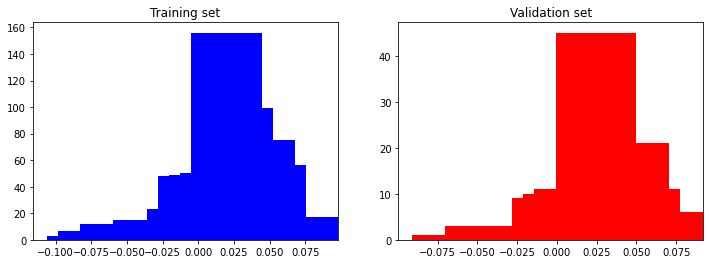

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

## Preprocess Data

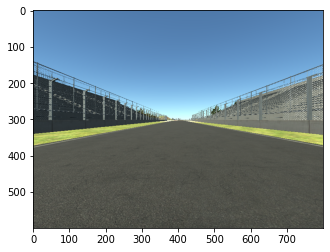

In [42]:
img_path = image_paths[0]
img = mpimg.imread(img_path)
plt.imshow(img)

In [45]:
import cv2

def img_preprocess(img):
    img = mpimg.imread(img)
    img = img[200:600,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3,3), 0)
    img = cv2.resize(img, (200,66))
    return img


Text(0.5, 1.0, 'Preprocessed image')

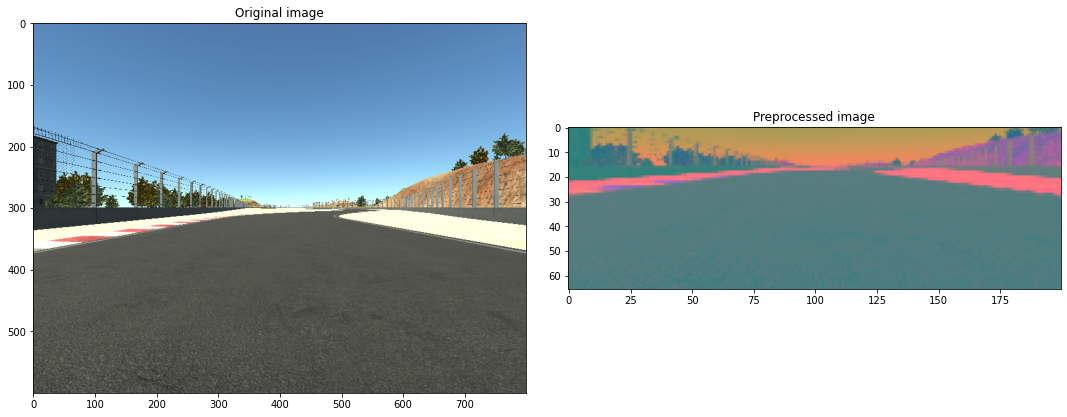

In [46]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)

fig, axs = plt.subplots(1,2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed image')

In [47]:
X_train = np.array(list(map(img_preprocess, X_train)))
X_valid = np.array(list(map(img_preprocess, X_valid)))

(776, 66, 200, 3)


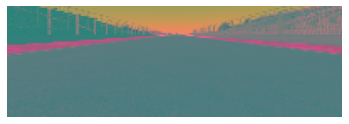

In [48]:
import random

plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off')
print(X_train.shape)


## NVIDIA Model

In [50]:
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense


def nvidia_model():
  model = Sequential()
  model.add(Conv2D(24, 5, 2, input_shape=(66, 200, 3), activation='elu'))
  model.add(Conv2D(36, 5, 2, activation='elu'))
  model.add(Conv2D(48, 5, 2, activation='elu'))
  model.add(Conv2D(64, 3, activation='elu'))
  
  model.add(Conv2D(64, 3, activation='elu'))
#   model.add(Dropout(0.5))
  
  
  model.add(Flatten())
  
  model.add(Dense(100, activation = 'elu'))
#   model.add(Dropout(0.5))
  
  model.add(Dense(50, activation = 'elu'))
#   model.add(Dropout(0.5))
  
  model.add(Dense(10, activation = 'elu'))
#   model.add(Dropout(0.5))
 
  model.add(Dense(1))
  
  optimizer = Adam(learning_rate=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  return model

model = nvidia_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               1

In [51]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), batch_size=100, verbose=1, shuffle = 1)

Epoch 1/30
8/8 [==============================] - 7s 426ms/step - loss: 0.7356 - val_loss: 0.0630
Epoch 2/30
8/8 [==============================] - 3s 367ms/step - loss: 0.0297 - val_loss: 0.0216
Epoch 3/30
8/8 [==============================] - 3s 424ms/step - loss: 0.0114 - val_loss: 0.0161
Epoch 4/30
8/8 [==============================] - 4s 469ms/step - loss: 0.0042 - val_loss: 0.0026
Epoch 5/30
8/8 [==============================] - 4s 431ms/step - loss: 0.0022 - val_loss: 0.0029
Epoch 6/30
8/8 [==============================] - 3s 374ms/step - loss: 0.0017 - val_loss: 9.1438e-04
Epoch 7/30
8/8 [==============================] - 3s 400ms/step - loss: 0.0012 - val_loss: 7.6210e-04
Epoch 8/30
8/8 [==============================] - 3s 430ms/step - loss: 8.6833e-04 - val_loss: 6.2971e-04
Epoch 9/30
8/8 [==============================] - 4s 473ms/step - loss: 7.5762e-04 - val_loss: 5.5613e-04
Epoch 10/30
8/8 [==============================] - 4s 455ms/step - loss: 5.9191e-04 - val_loss

Text(0.5, 0, 'Epoch')

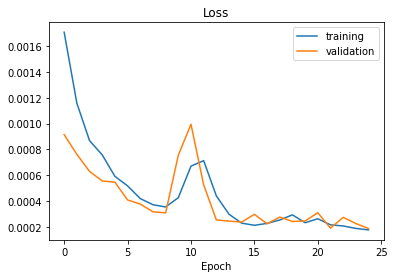

In [53]:
plt.plot(history.history['loss'][5:])
plt.plot(history.history['val_loss'][5:])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [55]:
date = "2021_10_15"
trial = 1
mdl = 'model-'+date+'-'+str(trial)
model.save("models/"+mdl)
print(f"Model {mdl} saved!")

INFO:tensorflow:Assets written to: models/model-2021_10_15-1\assets
Model model-2021_10_15-1 saved!


In [56]:
model.save("models/"+mdl+".h5")
print(f"{mdl}.h5 saved!")

model-2021_10_15-1.h5 saved!


## Test model

In [57]:
from keras.models import load_model
mdl = 'model-'+date+'-'+str(trial)
model = load_model("models/"+mdl+".h5")

In [64]:
data[200:]['center'].head()

200    000274.png
201    000275.png
202    000276.png
203    000277.png
204    000278.png
Name: center, dtype: object

Steering: real -0.086 - predicted -0.005342256277799606


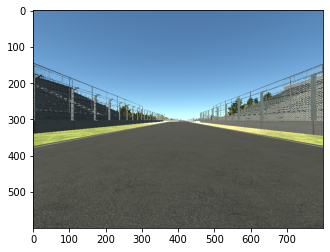

In [66]:
i = 42
image = '_out/frame_CameraRGB/'+data[200:]['center'].iloc[i]
preprocessed_image = img_preprocess(image) # driving_log not preprocessed, else need to add datadir+"/IMG/"+image

original_image = mpimg.imread(image)
plt.imshow(original_image)

input_image = np.array([preprocessed_image])
steering_angle = float(model.predict(input_image))

print("Steering: real "+str(data['steering'].loc[i])+" - predicted "+str(steering_angle))

In [69]:
predicted_angles = [float(model.predict(np.array([img_preprocess('_out/frame_CameraRGB/'+data[200:]['center'].iloc[i])]))) for i in range(len(data[200:]))]

In [70]:

pd.DataFrame(predicted_angles).to_csv("predicted_angles-"+date+".csv",index=False)

In [82]:
# data[200:]['steering'].plot()

In [83]:
actual_angles = data[200:]['steering'].to_list()

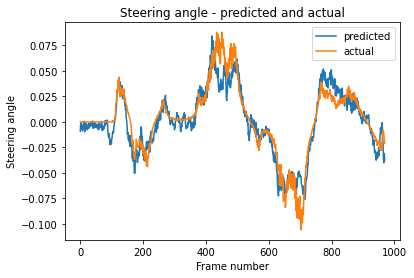

In [86]:
fig, ax = plt.subplots()
ax.plot(predicted_angles, label='predicted')
ax.plot(actual_angles, label='actual')
plt.xlabel('Frame number')
plt.ylabel('Steering angle')
plt.title("Steering angle - predicted and actual")
plt.legend()